# Inference Notebook

## Import of all needed scripts

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys

sys.path.insert(0, "../../src")

import matplotlib.pyplot as plt
import numpy as np
import torch

from juart.dl.checkpoint.manager import CheckpointManager
from juart.dl.data.inference import DatasetInference
from juart.dl.model.dc import DataConsistency
from juart.dl.model.unrollnet import ExponentialMovingAverageModel, UnrolledNet
from juart.dl.operation.modules import inference
# from juart.vis import MultiPlotter

In [2]:
# To improve performance, manually limit the number of threads
# torch.set_num_threads(16)
# torch.set_num_interop_threads(16)

## Load data
The DatasetInference is used to load a Dataset which is ready for inference. Next to the arguments the DatasetInference class will need to localize the data, it is also important to define the slice and the number of spokes which should be loaded from the dataset.

In [3]:
dataset = DatasetInference(
    "qrage/sessions/%s/preproc.zarr/preproc.zarr",
    ["7T1566"],
    [80],
    64,
    endpoint_url="https://s3.fz-juelich.de",
    backend="s3",
    device="cpu",
)

Extract the important data out of the dataset.

In [4]:
data = dataset[0:1]

Data - Started loading Dataset 7T1566 - Slice 80 ...
Data - Completed loading dataset in 3.4 seconds.
Data - Started regridding dataset ...
Data - Completed regridding dataset torch.Size([256, 256, 1, 2, 2]) in 0.2 seconds.


# Initialize CheckpointManager and model and run the inference

## Setup CheckpointManager
The CheckpointManager is used to load a trained model. First we do the setup and tell him where he has to search for the model files and then we can load specific properties out of the models directory. <br>Description of the complete CheckpointManager process: In the training notebook the CheckpointManager gets the input where it should save the model after every n itearations. When the model is trained and saved at the specific location, the CheckpointManger in the Inference notebook can load this model out of this specific location. In this way it is not only possible to use the completely trained model after nmax iterations but it is also possible to use the interim results to check if the model is going the right way.<br><br>

In [5]:
checkpoint_manager = CheckpointManager(
    directory="model_64spokes_epoch_1",
    root_dir="/home/jovyan/models",
    backend="local",
)

checkpoint = checkpoint_manager.load(
    ["averaged_model_state", "iteration"], map_location="cpu"
)

## Define the model and load a trained one with the CheckpointManager
nX: Number of x iterations on one y-coordinate<br>
nY: Number of y iterations on one x-coordinate<br>
nTI: Number of measurements during one T1-decay<br>
nTE: Number of measurements during one T2-decay<br>
<br>
The model gets defined and calibrated for the specific image, that should be reconstructed. Afterwards a trained model will be loaded with the help of the CheckpointManager. Due to this the parameters of the initialized model will be overwritten. At the end of the cell an output will be generated that gives information about the number of iterations the loaded model has been trained for.

In [6]:
shape = (256, 256, 1, 2, 2)

model = UnrolledNet(
    shape,
    features=64,
    CG_Iter=10,
    num_unroll_blocks=10,
    spectral_normalization=False,
    activation="ReLU",
    disable_progress_bar=False,
    device="cpu",
)

model = ExponentialMovingAverageModel(model, 0.9)
model.load_state_dict(checkpoint["averaged_model_state"])
iteration = checkpoint["iteration"]
print(f"Loaded averaged at iteration {iteration}.")

Loaded averaged at iteration 160.


## Image reconstruction with dl-qrage 
The MR image will be reconstructed with the data and the model we previously load. The device can be variated between the cpu and gpu. An Output will be generated which indicates the progress of the process.

In [7]:
images = inference(data, model, device="cpu")

100%|██████████| 10/10 [00:39<00:00,  3.90s/it]


# Compare to CG SENSE

## Set up and initialize CG SENSE reconstruction algorithm

In [8]:
dc_block = DataConsistency(
    shape,
    device="cpu",
)

In [9]:
dc_block.init(
    data["images_regridded"],
    data["kspace_trajectory"],
    sensitivity_maps=data["sensitivity_maps"],
)

## Image reconstruction with CG SENSE

In [10]:
with torch.no_grad():
    cg_sense = dc_block(data["images_regridded"])

# Display results
iTI and iTE define the number of measurement in the T1/T2 decay which should be illustrated.<br>
vmax defines the brightness normalization between 0 and vmax.

/tmp/ipykernel_1418610/751072254.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(cg_sense[:, :, 0, iTI, iTE]), cmap="gray", vmax=vmax)
/tmp/ipykernel_1418610/751072254.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(images[:, :, 0, iTI, iTE]), cmap="gray", vmax=vmax)


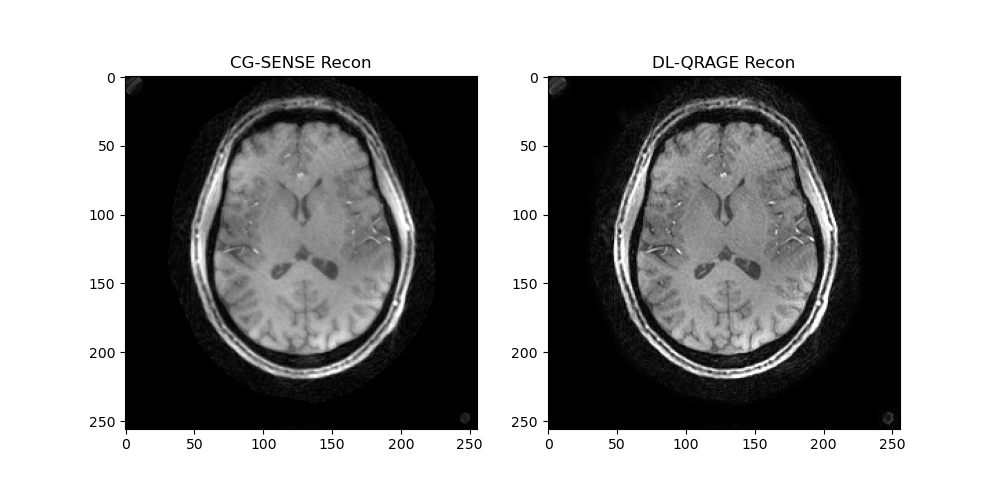

In [11]:
vmax = 2
iTI, iTE = 1, 0

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(cg_sense[:, :, 0, iTI, iTE]), cmap="gray", vmax=vmax)
plt.title("CG-SENSE Recon")
plt.subplot(1, 2, 2)
plt.imshow(np.abs(images[:, :, 0, iTI, iTE]), cmap="gray", vmax=vmax)
plt.title("DL-QRAGE Recon")
plt.show()